# Differentially Private Telemetry – Laplace Mechanism + Evaluation

This notebook is **self-contained** and does NOT import from `src/dp_Laplace_mechanism.py` or `src/dp_eval_laplace.py`. For better interaction and reproductions.

It implements:

1. **Non-private ground truth**
   - Load cleaned telemetry data (`telemetry_clean.csv`)
   - Build user-level "primary product" table
   - Compute user-level counts, error rates, and z-scores by product type

2. **Laplace DP mechanism (user-level, add/remove-one-user)**
   - Define L1 sensitivity for our query
   - Compute Laplace noise scale b from ε
   - Add noise **by hand** to user-level counts
   - Recompute DP error rates and DP z-scores

3. **Privacy / utility evaluation**
   - Run the DP mechanism for many runs (e.g. 100 different seeds)
   - Track:
     - L∞ error between true and DP z-scores
     - IOU between true vs DP "top set" (products with z > 0)
   - Summarize and visualize the distributions of these metrics

4. **Exploratory visualizations**
   - True vs DP z-scores for a single run
   - Boxplots of DP z-scores across runs (per product)
   - Histograms of L∞ and IOU

This notebook forms the **core experimental evidence** that our DP mechanism both:
- satisfies a reasonable ε-DP guarantee (by design), and
- preserves utility for the task of identifying high-error product types.


In [1]:
# -----------------------------
# Imports
# -----------------------------
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import zscore

plt.style.use("default")

# -----------------------------
# Paths
# -----------------------------
if os.path.basename(os.getcwd()) == "notebooks":
    ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
else:
    ROOT_DIR = os.getcwd()

PROC_DIR = os.path.join(ROOT_DIR, "data", "processed")
REPORT_DIR = os.path.join(ROOT_DIR, "reports")
os.makedirs(REPORT_DIR, exist_ok=True)

CLEAN_PATH = os.path.join(PROC_DIR, "telemetry_clean.csv")

ROOT_DIR, CLEAN_PATH


('/Users/revaagrawal/Desktop/DSC_180A-Section_B15-Quater_1-Project',
 '/Users/revaagrawal/Desktop/DSC_180A-Section_B15-Quater_1-Project/data/processed/telemetry_clean.csv')

## 1. Load Cleaned Telemetry Data

We assume `preprocess.py` has already written:

- `data/processed/telemetry_clean.csv`

with columns:

- `Product Type`
- `Event Type`
- `Time of Event` (datetime)
- `event_date`
- `event_hour`
- `event_dow`
- `is_weekend`
- `User ID`


In [ ]:
df = pd.read_csv(CLEAN_PATH, parse_dates=["Time of Event"])
print("Clean telemetry shape:", df.shape)
df.head()


Clean telemetry shape: (152356, 8)


,Product Type,Event Type,Time of Event,event_date,event_hour,event_dow,is_weekend,User ID
0,C,open,2024-05-14 07:34:33,2024-05-14,7,1,0,1a377331f95e
1,E,close,2024-06-17 14:43:26,2024-06-17,14,0,0,1866bf611f3d
2,C,close,2024-07-13 05:20:43,2024-07-13,5,5,1,51985c68b545
3,D,open,2024-06-11 17:39:05,2024-06-11,17,1,0,a0ab7ed6e10b
4,C,save,2024-06-23 18:20:35,2024-06-23,18,6,1,26e0c22f0ca0


## 2. User-Level "Primary Product" Representation

We want **user-level DP** (add/remove-one-user), not event-level DP.

If we naïvely counted events per product, a single user touching many products could
affect many counts, which complicates the sensitivity analysis.

To keep things clean:

1. For each `(User ID, Product Type)`, we aggregate:
   - `n_events`: number of events this user generated for this product
   - `any_error`: did this user ever have an `error` event on this product?

2. Then we choose **one primary product per user**:
   - The product where the user has the **largest number of events**.
   - If there is a tie, pandas' `idxmax()` just picks the first.

This guarantees:
- Each user contributes to counts for **exactly one product**.
- For that product, they can affect:
  - `U_total_P` by at most +1 or -1
  - `U_error_P` by at most +1 or -1
- This makes the L1 sensitivity simple and explicit.


In [ ]:
def build_user_level_primary_product(df: pd.DataFrame):
    """
    Collapse telemetry data to one row per (User ID, Product Type),
    then pick a SINGLE primary product per user.

    Returns a DataFrame with columns:
        - User ID
        - Product Type  (primary product for that user)
        - n_events      (# of events on that product)
        - any_error     (True if user had at least one 'error' on that product)
    """
    user_prod = (
        df.groupby(["User ID", "Product Type"])
          .agg(
              n_events=("Event Type", "size"),
              any_error=("Event Type", lambda x: (x == "error").any())
          )
          .reset_index()
    )

    idx = user_prod.groupby("User ID")["n_events"].idxmax()
    primary = user_prod.loc[idx].copy()

    assert primary["User ID"].is_unique, "Expected one primary product per user."

    return primary


primary = build_user_level_primary_product(df)
print("Primary-product table shape:", primary.shape)
primary.head()

Primary-product table shape: (137232, 4)


,User ID,Product Type,n_events,any_error
0,000011ba1d30,A,1,False
1,000119f35600,A,1,False
2,00020611a1b5,B,1,False
3,000263904f75,E,1,False
4,0002c1ebd30d,Others,1,False


## 3. TRUE User-Level Counts and Error-Rate Z-Scores

Using the primary-product view, we define for each product type **P**:

- `U_total_P` = number of users whose primary product is P  
- `U_error_P` = number of those users who had at least one `error` on P  

Then:

- `error_rate_true_P = U_error_P / U_total_P` (for products with `U_total_P > 0`)  
- `z_true_P` = z-score of `error_rate_true` across all product types  

This gives us the **non-private ground truth** at the user level.


In [ ]:
def compute_true_user_level_counts(primary: pd.DataFrame):
    """
    Given the primary-product DataFrame, compute TRUE user-level counts and z-scores.

    Returns a DataFrame indexed by Product Type with columns:
        - U_total
        - U_error
        - error_rate_true
        - z_true
    """

    U_total = (
        primary.groupby("Product Type")["User ID"]
               .nunique()
               .rename("U_total")
    )

    primary_error = primary[primary["any_error"]]
    U_error = (
        primary_error.groupby("Product Type")["User ID"]
                     .nunique()
                     .rename("U_error")
    )

    counts = pd.concat([U_total, U_error], axis=1).fillna(0)
    counts["U_total"] = counts["U_total"].astype(int)
    counts["U_error"] = counts["U_error"].astype(int)

    counts["error_rate_true"] = 0.0
    nonzero = counts["U_total"] > 0
    counts.loc[nonzero, "error_rate_true"] = (
        counts.loc[nonzero, "U_error"] / counts.loc[nonzero, "U_total"]
    )

    if counts["error_rate_true"].nunique() > 1:
        counts["z_true"] = zscore(counts["error_rate_true"])
    else:
        counts["z_true"] = 0.0

    return counts


true_counts = compute_true_user_level_counts(primary)
true_counts


,U_total,U_error,error_rate_true,z_true
Product Type,,,,
A,20802,114,0.005480,-0.898460
B,34541,674,0.019513,-0.396586
C,25658,36,0.001403,-1.044277
D,27495,2430,0.088380,2.066386
E,1410,26,0.018440,-0.434973
F,13576,680,0.050088,0.696922
Others,13750,425,0.030909,0.010987


In [ ]:
z_true = true_counts["z_true"]

def get_top_set_from_zscores(z_series: pd.Series, threshold: float = 0.0):
    """
    Return the set of product types with z-score > threshold.
    """
    mask = z_series > threshold
    return set(z_series.index[mask])

true_top = get_top_set_from_zscores(z_true)

print("TRUE z-scores:")
print(z_true)
print("\nTRUE top set (z_true > 0):", true_top)


TRUE z-scores:
Product Type
A        -0.898460
B        -0.396586
C        -1.044277
D         2.066386
E        -0.434973
F         0.696922
Others    0.010987
Name: z_true, dtype: float64

TRUE top set (z_true > 0): {'D', 'F', 'Others'}


## 4. Laplace DP Mechanism (User-Level, Add/Remove-One-User)

We now design a **user-level** Laplace mechanism.

- Query vector:
  $
    f(D) = (\dots, U_{total,P}, U_{error,P}, \dots)
  $
  over all products P.

- Neighboring datasets:
  - `D` and `D'` differ by **adding or removing one user**.

By our primary-product construction:
- A single user is assigned to **one product** P only.
- For that product,
  - `U_total_P` can change by at most ±1,
  - `U_error_P` can change by at most ±1.

So for the concatenated vector `[U_total_P, U_error_P]` for that one product, the
change in L1 norm is:

$
\Delta_1 = |1| + |1| = 2.
$

We use the classic Laplace mechanism formula for ε-DP:

$
b = \frac{\Delta_1}{\varepsilon}.
$

We then:
- Add independently `Laplace(0, b)` noise to each `U_total_P` and `U_error_P`.
- Clamp noisy counts at 0 (counts can't be negative).
- Compute DP error rates and DP z-scores from the noisy counts.


In [ ]:
DEFAULT_EPSILON = 2.0

L1_SENSITIVITY = 2.0


def laplace_scale(l1_sensitivity: float, epsilon: float):
    """
    Compute Laplace noise scale (b) for epsilon-DP:

        b = Δ_1 / ε

    where:
        Δ_1 = L1 sensitivity of f(D).
    """
    return l1_sensitivity / epsilon


def add_laplace_noise_to_counts(
    counts: pd.DataFrame,
    epsilon: float = DEFAULT_EPSILON,
    random_state: int | None = None,
):
    """
    Apply the Laplace DP mechanism to (U_total, U_error) per product.

    - `counts` is the true user-level counts DataFrame with columns:
        U_total, U_error, error_rate_true, z_true.

    - Returns a NEW DataFrame with extra columns:
        U_total_noisy, U_error_noisy, error_rate_dp, z_dp.
    """

    rng = np.random.default_rng(seed=random_state)

    noisy = counts.copy()

    scale = laplace_scale(L1_SENSITIVITY, epsilon)
    print(f"[DP] Using scale = {scale:.4f} for Laplace noise.")

    for col in ["U_total", "U_error"]:
        noise = rng.laplace(loc=0.0, scale=scale, size=len(noisy))
        noisy[f"{col}_noisy"] = noisy[col].astype(float) + noise
        noisy[f"{col}_noisy"] = noisy[f"{col}_noisy"].clip(lower=0.0)

    noisy["error_rate_dp"] = 0.0
    nonzero = noisy["U_total_noisy"] > 0
    noisy.loc[nonzero, "error_rate_dp"] = (
        noisy.loc[nonzero, "U_error_noisy"] / noisy.loc[nonzero, "U_total_noisy"]
    )

    if noisy["error_rate_dp"].nunique() > 1:
        noisy["z_dp"] = zscore(noisy["error_rate_dp"])
    else:
        noisy["z_dp"] = 0.0

    return noisy


[DP] Using scale = 1.0000 for Laplace noise.
DP z-scores (single run):
Product Type
A        -0.891317
B        -0.392399
C        -1.040920
D         2.068124
E        -0.452246
F         0.697329
Others    0.011430
Name: z_dp, dtype: float64

DP top set (z_dp > 0): {'D', 'F', 'Others'}


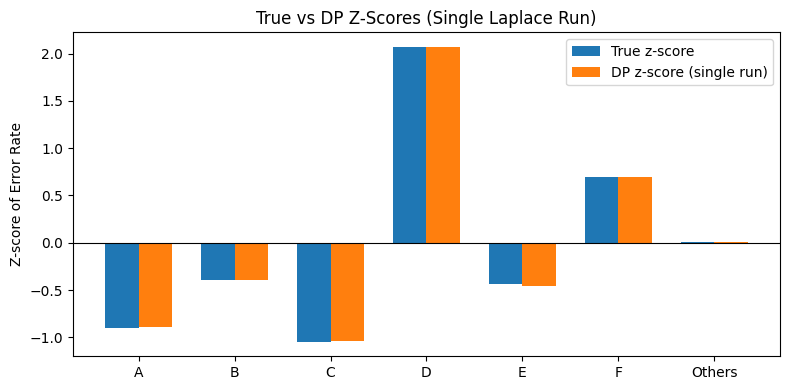

In [ ]:
seed_single = 2025

noisy_single = add_laplace_noise_to_counts(
    true_counts,
    epsilon=DEFAULT_EPSILON,
    random_state=seed_single,
)

z_dp_single = noisy_single["z_dp"]
dp_top_single = get_top_set_from_zscores(z_dp_single)

print("DP z-scores (single run):")
print(z_dp_single)
print("\nDP top set (z_dp > 0):", dp_top_single)

products = z_true.index.astype(str)
x = np.arange(len(products))
width = 0.35

plt.figure(figsize=(8, 4))
plt.bar(x - width / 2, z_true.values, width, label="True z-score")
plt.bar(x + width / 2, z_dp_single.values, width, label="DP z-score (single run)")

plt.xticks(x, products)
plt.axhline(0, color="black", linewidth=0.8)
plt.ylabel("Z-score of Error Rate")
plt.title("True vs DP Z-Scores (Single Laplace Run)")
plt.legend()
plt.tight_layout()
plt.show()


## 6. Evaluation Metrics: L∞ and IOU

We follow the assignment and evaluate our DP mechanism using:

1. **L∞ error on z-scores**:
   $
     L_\infty = \max_P |z^\text{true}_P - z^\text{DP}_P|
   $
   where P ranges over all product types.

2. **IOU on top sets**:

   Let:
   - `S_true` = set of products with `z_true > 0`
   - `S_dp`   = set of products with `z_dp > 0`

   Then:
   $
     \text{IOU}(S_\text{true}, S_\text{dp}) =
     \frac{|S_\text{true} \cap S_\text{dp}|}{|S_\text{true} \cup S_\text{dp}|}.
   $

We will run the DP mechanism **R times** (e.g. 100), each time with a different random seed,
and compute L∞ and IOU for each run.


In [ ]:
def compute_l_inf_error(true_z: pd.Series, dp_z: pd.Series):
    """
    Compute L_infinity error between true and DP z-score vectors:
        max_P |z_true[P] - z_dp[P]|
    """
    true_aligned, dp_aligned = true_z.align(dp_z, join="inner")
    return float(np.max(np.abs(true_aligned - dp_aligned)))


def compute_iou(true_set: set, dp_set: set):
    """
    Compute Intersection over Union (IOU) between two sets.
    IOU = |true ∩ dp| / |true ∪ dp|
    """
    intersection = len(true_set.intersection(dp_set))
    union = len(true_set.union(dp_set))
    return intersection / union if union > 0 else 0.0


def summarize_metric_array(values: list[float]):
    """
    Summarize a list of values by:
        - max
        - min
        - 5% quantile
        - 50% quantile (median)
        - 95% quantile
    """
    arr = np.asarray(values)
    return {
        "max": float(np.max(arr)),
        "min": float(np.min(arr)),
        "5%": float(np.percentile(arr, 5)),
        "50%": float(np.percentile(arr, 50)),
        "95%": float(np.percentile(arr, 95)),
    }


## 7. Multiple DP Runs (e.g. 100) – L∞ and IOU

We now:

- Fix the mechanism (same ε, sensitivity).
- For `num_runs = 100`:
  - Use a different seed each time.
  - Add fresh Laplace noise.
  - Recompute DP z-scores.
  - Compute L∞ and IOU.

We store the results in memory, and optionally write a **single** CSV
for all runs (not 100 separate files).


In [ ]:
num_runs = 100
base_seed = 12345

l_inf_values = []
iou_values = []

z_dp_runs = []

true_top_set = true_top

for run_idx in range(num_runs):
    seed = base_seed + run_idx
    print(f"[Eval] Run {run_idx+1}/{num_runs}, seed={seed}")

    noisy = add_laplace_noise_to_counts(
        true_counts,
        epsilon=DEFAULT_EPSILON,
        random_state=seed,
    )

    z_dp = noisy["z_dp"]
    dp_top_set = get_top_set_from_zscores(z_dp)

    l_inf = compute_l_inf_error(z_true, z_dp)
    iou = compute_iou(true_top_set, dp_top_set)

    l_inf_values.append(l_inf)
    iou_values.append(iou)
    z_dp_runs.append(z_dp)

runs_df = pd.DataFrame(
    {
        "run": np.arange(num_runs),
        "L_inf": l_inf_values,
        "IOU": iou_values,
    }
)

runs_df.head()


[Eval] Run 1/100, seed=12345
[DP] Using scale = 1.0000 for Laplace noise.
[Eval] Run 2/100, seed=12346
[DP] Using scale = 1.0000 for Laplace noise.
[Eval] Run 3/100, seed=12347
[DP] Using scale = 1.0000 for Laplace noise.
[Eval] Run 4/100, seed=12348
[DP] Using scale = 1.0000 for Laplace noise.
[Eval] Run 5/100, seed=12349
[DP] Using scale = 1.0000 for Laplace noise.
[Eval] Run 6/100, seed=12350
[DP] Using scale = 1.0000 for Laplace noise.
[Eval] Run 7/100, seed=12351
[DP] Using scale = 1.0000 for Laplace noise.
[Eval] Run 8/100, seed=12352
[DP] Using scale = 1.0000 for Laplace noise.
[Eval] Run 9/100, seed=12353
[DP] Using scale = 1.0000 for Laplace noise.
[Eval] Run 10/100, seed=12354
[DP] Using scale = 1.0000 for Laplace noise.
[Eval] Run 11/100, seed=12355
[DP] Using scale = 1.0000 for Laplace noise.
[Eval] Run 12/100, seed=12356
[DP] Using scale = 1.0000 for Laplace noise.
[Eval] Run 13/100, seed=12357
[DP] Using scale = 1.0000 for Laplace noise.
[Eval] Run 14/100, seed=12358
[DP]

,run,L_inf,IOU
0,0,0.048547,0.666667
1,1,0.026659,1.000000
2,2,0.009185,1.000000
3,3,0.018153,1.000000
4,4,0.001538,1.000000


In [ ]:
runs_csv_path = os.path.join(REPORT_DIR, "dp_eval_runs_laplace_notebook.csv")
runs_df.to_csv(runs_csv_path, index=False)
print("Saved per-run metrics to:", runs_csv_path)

l_inf_summary = summarize_metric_array(l_inf_values)
iou_summary = summarize_metric_array(iou_values)

summary = {
    "epsilon": DEFAULT_EPSILON,
    "num_runs": num_runs,
    "L_inf_summary": l_inf_summary,
    "IOU_summary": iou_summary,
}

summary_path = os.path.join(REPORT_DIR, "dp_eval_summary_laplace_notebook.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

print("Summary:")
print(json.dumps(summary, indent=2))


Saved per-run metrics to: /Users/revaagrawal/Desktop/DSC_180A-Section_B15-Quater_1-Project/reports/dp_eval_runs_laplace_notebook.csv
Summary:
{
  "epsilon": 2.0,
  "num_runs": 100,
  "L_inf_summary": {
    "max": 0.08185574513015903,
    "min": 0.0015380761774128615,
    "5%": 0.0022702185251277734,
    "50%": 0.014152813627755417,
    "95%": 0.05364714214600566
  },
  "IOU_summary": {
    "max": 1.0,
    "min": 0.6666666666666666,
    "5%": 0.9833333333333334,
    "50%": 1.0,
    "95%": 1.0
  }
}


In [ ]:
# Convert list of Series into a DataFrame:
#   - rows = runs
#   - columns = product types
z_dp_df = pd.DataFrame(z_dp_runs)
z_dp_df.index.name = "run"
z_dp_df.columns.name = "Product Type"

z_dp_df.head()


Product Type,A,B,C,D,E,F,Others
run,,,,,,,
z_dp,-0.911580,-0.405632,-1.053258,2.065402,-0.386425,0.692764,-0.001271
z_dp,-0.905443,-0.402028,-1.049436,2.067220,-0.408313,0.690695,0.007305
z_dp,-0.895684,-0.397271,-1.044465,2.063618,-0.444157,0.702121,0.015838
z_dp,-0.901706,-0.400526,-1.048771,2.066813,-0.416819,0.693597,0.007413
z_dp,-0.897361,-0.396619,-1.044098,2.067594,-0.434399,0.695384,0.009498


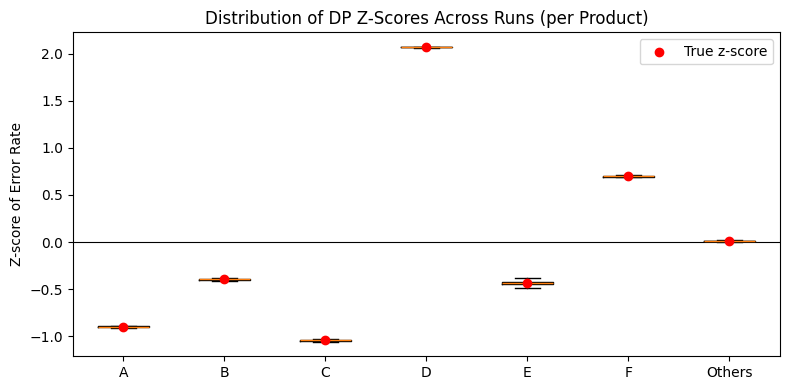

In [ ]:
products = z_dp_df.columns.tolist()

plt.figure(figsize=(8, 4))

z_data = [z_dp_df[p].values for p in products]
plt.boxplot(z_data, tick_labels=products, showfliers=False)

plt.scatter(
    x=np.arange(1, len(products) + 1),
    y=z_true[products].values,
    color="red",
    label="True z-score",
    zorder=3,
)

plt.axhline(0, color="black", linewidth=0.8)
plt.ylabel("Z-score of Error Rate")
plt.title("Distribution of DP Z-Scores Across Runs (per Product)")
plt.legend()
plt.tight_layout()
plt.show()


## 9. Histograms of L∞ and IOU

These plots show how much the DP mechanism typically deviates
from the true z-scores, and how often it recovers the correct
set of problematic products.


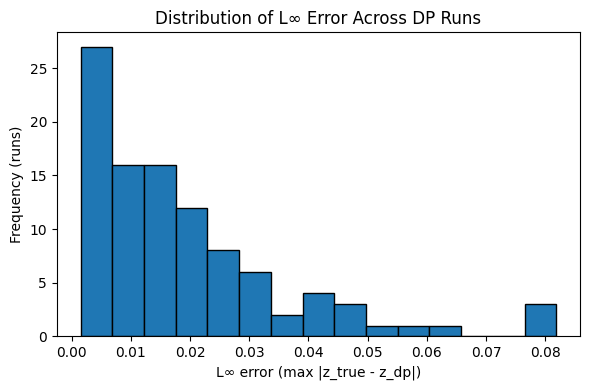

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(runs_df["L_inf"], bins=15, edgecolor="black")
plt.xlabel("L∞ error (max |z_true - z_dp|)")
plt.ylabel("Frequency (runs)")
plt.title("Distribution of L∞ Error Across DP Runs")
plt.tight_layout()
plt.show()


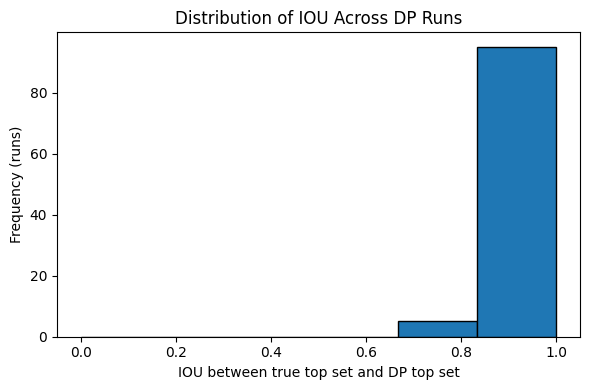

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(runs_df["IOU"], bins=np.linspace(0, 1, 7), edgecolor="black", align="mid")
plt.xlabel("IOU between true top set and DP top set")
plt.ylabel("Frequency (runs)")
plt.title("Distribution of IOU Across DP Runs")
plt.xticks(np.linspace(0, 1, 6))
plt.tight_layout()
plt.show()


## 10. Check the Laplace Noise Distribution

This is just a sanity check that the noise we're drawing looks like
a zero-mean Laplace distribution with the expected scale parameter b.


Scale (b) used by Laplace mechanism: 1.0


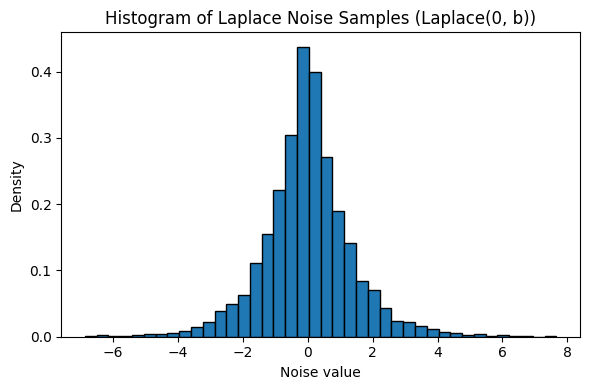

In [ ]:
scale = laplace_scale(L1_SENSITIVITY, DEFAULT_EPSILON)
print("Scale (b) used by Laplace mechanism:", scale)

rng = np.random.default_rng(seed=42)
noise_samples = rng.laplace(loc=0.0, scale=scale, size=5000)

plt.figure(figsize=(6, 4))
plt.hist(noise_samples, bins=40, density=True, edgecolor="black")
plt.xlabel("Noise value")
plt.ylabel("Density")
plt.title("Histogram of Laplace Noise Samples (Laplace(0, b))")
plt.tight_layout()
plt.show()


## 11. Summary

In this **notebook**, we:

- Built a **user-level primary product** view for add/remove-one-user DP.
- Computed **true user-level error rates and z-scores** per product type.
- Designed a **Laplace DP mechanism** with:
  - L1 sensitivity Δ₁ = 2
  - ε = 2.0 (pure epsilon-DP, no delta)
  - b chosen by the standard Laplace mechanism formula: b = Δ₁/ε
- Implemented noise addition **by hand** to (U_total, U_error) per product.
- Recomputed **DP error rates and DP z-scores** from noisy counts.
- Ran **100 DP trials**, measuring:
  - L∞ error between true and DP z-scores
  - IOU between true and DP top sets (z > 0)
- Visualized:
  - True vs DP z-scores (single run)
  - Distribution of DP z-scores across runs (boxplots)
  - Histograms of L∞ and IOU
  - Noise distribution itself

This provides both:
- A clear, inspectable implementation of the Laplace DP mechanism, and
- Empirical evidence of its utility for detecting high-error product types.